<a href="https://colab.research.google.com/github/MangoDingo33/Study/blob/main/%ED%8A%B9%EA%B0%95/0926_AdversarialAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import drive
drive.mount('/content/drive')

from __future__ import print_function

import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import os
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
path = '/content/drive/MyDrive/Colab Notebooks/ResNet_FGSM/test/0.05'
os.makedirs(path, exist_ok=True)

folders = [path+'/airplane', path+'/automobile', path+'/bird', path+'/cat', path+'/deer', path+'/dog', path+'/frog', path+'/horse', path+'/ship', path+'/truck']
for path in folders:
  os.makedirs(path, exist_ok=True)

In [60]:
# #공격함수 정의

# def fgsm_attack(image, epsilon, data_grad):

#   #data_grad의 요소별 부호값 얻어오기
#   sign_data_grad = data_grad.sign()
#   #입력 이미지의 각 픽셀에 sign_data_grad를 적용해 이미지 생성
#   perturbed_image = image + epsilon * sign_data_grad
#   #값 범위를 [0, 1]로 유지하기 위해 자르기(clipping)
#   perturbed_image = torch.clamp(perturbed_image, 0, 1)
#   #작은 변화가 적용된 이미지 반환
#   return perturbed_image

# #적대적 예제 생성 및 저장함수 정의
# def ax_create(model, device, test_loader, epsilon):

#   label_class = 'null'
#   #정확도 Counter
#   correct = 0
#   adv_examples = []
#   img_len = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#   loop = tqdm(enumerate(test_loader), total = len(test_loader))

#   for i, data in loop:
#     inputs, labels = data
#     inputs, labels = inputs.to(device), labels.to(device)

#     #텐서의 속성 중 reqires_grad 설정
#     inputs.reqires_grad = True

#     #데이터를 모델에 통과시킴
#     output = model(inputs)
#     init_pred = output.max(1, keepdim = True)[1]#로그확룰의 최대값을 가지는 인덱스 얻기
#     init_pred = init_pred.squeeze()

#     #손실값 계산
#     loss = F.nll_loss(output, labels)
#     #모델의 변화도들을 모두 0으로 설정
#     model.zero_grad()
#     #backpropagation을 통해 모델의 변화도 계산
#     loss.backward()
#     #변화도 값 수집
#     data_grad = inputs.grad

#     #공격함수 호출
#     perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

#     #perturbation이 적용된 이미지를 재분류(검증)
#     output = model(perturbed_data)

#     #로그 확률의 최대값을 가지는 인덱스 저장
#     final_pred = output.max(1, keepdim = True)[1]

#     if final_pred.squeeze() == labels.squeeze():
#       correct += 1

#     adv_ex = perturbed_data.squeeze().detach().cpu().numpy()

#     #생성할 적대적예제 갯수 지정 (ax_n 변수로 지정)
#     label_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#     ax_n = 2

#     label_index = int(labels.item())

#     if label_index < len(label_classes):
#       if img_len[label_index] < ax_n:
#         label_class = label_classes[label_index]
#         img_len[label_index] += 1
#       else:
#         continue

#     plt.imshow(np.transpose(adv_ex, (1,2,0)))
#     plt.axis('off')
#     ax_path = '/content/drive/MyDrive/Colab Notebooks/resNet_FGSM/test/'
#     plt.savefig(ax_path + str(epsilon)+'/' + label_class+'/'+str(i)+'/'+'.png',bbox_inches='tight', pad_inches = 0)

# FGSM 공격 함수 정의
def fgsm_attack(image, epsilon, data_grad):

    # data_grad 의 요소별 부호 값을 얻어오기
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성
    perturbed_image = image + epsilon*sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지 반환
    return perturbed_image


#적대적 예제 생성 및 저장 함수 정의
def ax_create( model, device, test_loader, epsilon ):

    label_class = "null"
    # 정확도 Counter
    correct = 0
    adv_examples = []
    img_len = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    loop = tqdm(enumerate(test_loader), total=len(test_loader))

    for i, data in loop:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 텐서의 속성 중 requires_grad 설정(중요)
        inputs.requires_grad = True

        # 데이터를 모델에 통과시킴
        output = model(inputs)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스 얻기
        init_pred = init_pred.squeeze()

        # 손실값 계산
        loss = F.nll_loss(output, labels)
        # 모델의 변화도들을 전부 0으로 설정
        model.zero_grad()
        # Backpropagation을 통해 모델의 변화도 계산
        loss.backward()
        # 변화도 값 수집
        data_grad = inputs.grad

        # FGSM 공격 함수 호출
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

        # Perturbation이 적용된 이미지를 재분류 (검증)
        output = model(perturbed_data)

        # 로그 확률의 최대값을 가지는 인덱스 저장
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.squeeze() == labels.squeeze():
            correct += 1

        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()

        #생성할 적대적예제 갯수 지정 (ax_n 변수로 지정)
        label_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        ax_n = 10

        #생성할 적대적 예제 만큼 악성 이미지 생성
        label_index = int(labels.item())

        if label_index < len(label_classes):
          if img_len[label_index] < ax_n:
            label_class = label_classes[label_index]
            img_len[label_index] += 1
          else:
            continue

        plt.imshow(np.transpose(adv_ex, (1, 2, 0)))
        plt.axis('off')
        ax_path = "/content/drive/MyDrive/Colab Notebooks/ResNet_FGSM/test/"
        plt.savefig(ax_path + str(epsilon) + '/' + label_class + '/' + str(i) + '.png', bbox_inches='tight', pad_inches=0)


Files already downloaded and verified
CUDA Available:  True


100%|██████████| 10000/10000 [08:37<00:00, 19.31it/s]


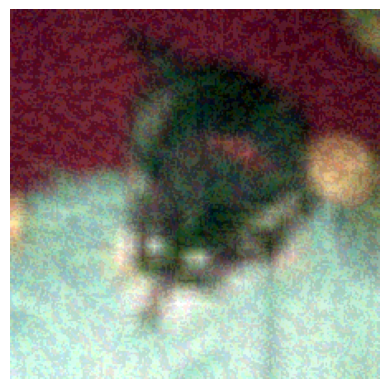

In [61]:
# #공격을 위한 강도 지정
# epsilon = 0.05

# trans = transforms.Compose([transforms.Resize((224,224)),
#                            transforms.ToTensor(),
#                            ])
# test_set = torchvision.datasets.CIFAR10(
#     root='./data', train = False, download = True, transform = trans)
# test_loader = torch.utils.data.DataLoader(
#     test_set, batch_size = 1, shuffle = False, num_workers = 0)

# print('CUDA Available: ', torch.cuda.is_available())
# device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
# #타깃 모델 불러오기
# model = models.resnet50(pretrained = True)
# num_classes = 10
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# #타깃모델 가중치 불러오기
# path = '/content/drive/MyDrive/Colab Notebooks/Cifar_Best_resnet50.pth'
# model.load_state_dict(torch.load(path))

# model.to(device)
# model.eval()#모델 평가모드로

# #엡실론에 대한 적대적 예제 생성함수 호출
# acc = ax_create(model, device, test_loader, epsilon)

#FGSM 공격을 위한 강도 지정
epsilon = 0.05

# 테스트 데이터셋과 데이터로더 선언
trans = transforms.Compose([transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            ])
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=trans)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1, shuffle=False, num_workers=0)

# GPU 할당
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

#타깃 모델 load
model = models.resnet50(pretrained=True)
num_classes = 10
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs,num_classes)

#타깃 모델 가중치 load
path = "/content/drive/MyDrive/Colab Notebooks/Cifar_Best_resnet50.pth"
model.load_state_dict(torch.load(path))

model.to(device)
model.eval() #모델 평가모드로 (중요)

#Epsilon에 대한 적대적예제 생성함수 호출
acc = ax_create(model, device, test_loader, epsilon)

In [64]:
#생성한 적대적 예제로 모델 정확도 검증

#모델 검증 함수 정의
def model_test_visualization(test_set):
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
  my_data = [] #정답 list
  y_pred_list = [] #예측 list

  # 정답 list 입력
  for i, (input, target) in enumerate(test_loader):
      my_data.append(target)

  # 예측 list 입력
  with torch.no_grad():
      for X_batch, _ in test_loader:
          X_batch = X_batch.to(device)
          y_test_pred = model(X_batch)
          y_pred_softmax = torch.log_softmax(y_test_pred, dim=1)
          _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
          y_pred_list.append(y_pred_tags.cpu().numpy())

  # list squeeze
  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  my_data = [a.squeeze().tolist() for a in my_data]

  answer = []
  for element in my_data:
      answer.append(element)
  question = []
  for element in y_pred_list:
      question.append(element)

  # list -> tensor
  my_data = torch.tensor(answer)
  y_pred_list = torch.tensor(question)

  # Confusion-matrix 이미지 출력
  confusion_mx = pd.DataFrame(confusion_matrix(my_data, y_pred_list))
  ax =sns.heatmap(confusion_mx, annot=True, fmt='g')
  plt.title('ResNet Confusion Matrix', fontsize=20)
  plt.show()

  #값 출력
  f1_score_detail= classification_report(my_data, y_pred_list)
  print(f1_score_detail)

  print(f"precision : {precision_score(my_data, y_pred_list, average='macro')}")
  print(f"recall : {recall_score(my_data, y_pred_list, average='macro')}")
  print(f"f1 score : {f1_score(my_data, y_pred_list, average='macro')}")
  print(f"accuracy : {accuracy_score(my_data, y_pred_list)}")

#정상 테스트셋 load 및 test 함수
def original_test():
  print("")
  print("******* Orignal Dataset Test *******")
  print("")
  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)
  model_test_visualization(test_set)

#적대적예제 테스트셋(악성) load 및 test 함수
def adversarial_test():
  print("")
  print("******* Adversarial Example Test *******")
  print("")
  ax_example_path = "/content/drive/MyDrive/Colab Notebooks/ResNet_FGSM/test/0.05/"
  test_set = torchvision.datasets.ImageFolder(root = ax_example_path, transform = trans)
  model_test_visualization(test_set)


******* Orignal Dataset Test *******

Files already downloaded and verified


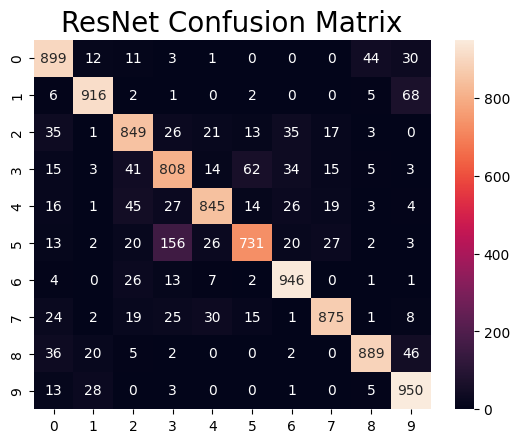

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1000
           1       0.93      0.92      0.92      1000
           2       0.83      0.85      0.84      1000
           3       0.76      0.81      0.78      1000
           4       0.90      0.84      0.87      1000
           5       0.87      0.73      0.79      1000
           6       0.89      0.95      0.92      1000
           7       0.92      0.88      0.90      1000
           8       0.93      0.89      0.91      1000
           9       0.85      0.95      0.90      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

precision : 0.872499227405146
recall : 0.8708
f1 score : 0.8703570717294877
accuracy : 0.8708


In [65]:
#test 함수 호출 (원본 데이터셋)
original_test()


******* Adversarial Example Test *******



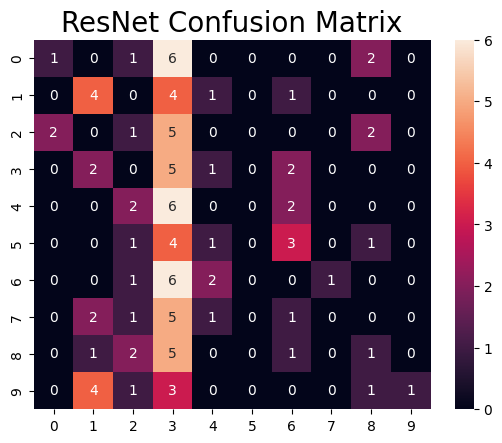

              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.31      0.40      0.35        10
           2       0.10      0.10      0.10        10
           3       0.10      0.50      0.17        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.14      0.10      0.12        10
           9       1.00      0.10      0.18        10

    accuracy                           0.13       100
   macro avg       0.20      0.13      0.11       100
weighted avg       0.20      0.13      0.11       100

precision : 0.19859236002093145
recall : 0.13000000000000003
f1 score : 0.10706290068681157
accuracy : 0.13


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [66]:
#test 함수 호출 (적대적 예제)
adversarial_test()